# Cooperative Kernel regression

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

## **Partie 1 :** 

Solvers pour les différentes méthodes (on a choisi de faire de la POO)

In [84]:
def kernel(x,y):
    return np.exp(-(x-y)**2)


class instance:
    def __init__(self,all_x,x,y,agents_x,agents_y,adjacence_matrix,sigma) -> None:
        self.X=x
        self.all_X = all_x
        self.Y=y
        self.agents = agents_x
        self.agents_y = agents_y
        self.adjacence_matrix = adjacence_matrix
        self.sigma = sigma
        data_size = np.shape(x)[0]
        n = np.shape(all_x)[0]
        self.n = n
        self.data_size = data_size
        self.Knn_matrix = np.array([[kernel(x[k],x[l]) for k in range(data_size)]for l in range(data_size)])
        self.Knm_matrix = np.array([[kernel(x[k],all_x[l]) for k in range(data_size)]for l in range(self.n)])
        number_of_agents,data_per_agent = np.shape(agents_x)
        _,data_per_agent_y = np.shape(agents_y)
        self.number_of_agents = number_of_agents
        self.data_per_agent = data_per_agent
        self.data_per_agent_y = data_per_agent_y
        matrixA = np.identity(number_of_agents*data_size)
        for index in range(data_size):
                matrixA[(number_of_agents-1)*data_size+index,(number_of_agents-1)*data_size+index]=0
        for index in range((number_of_agents-1)*data_size):
                matrixA[index,index+data_size]=-1
        self.matrixA = matrixA
        self.true_solution = np.zeros(10)

    def objective(self,curent_solution):
        objecti = np.dot(curent_solution,np.dot(self.Knn_matrix,curent_solution))/2
        for agent_index in range(self.number_of_agents):
            for agent_index_2 in range(self.data_per_agent_y):
                matrix_Kim = np.array([kernel(self.all_X[self.agents_y[agent_index,agent_index_2]],self.X[j]) for j in range(self.data_size)])
                objecti+=(1/(2*(self.sigma**2)))*(self.Y[self.agents_y[agent_index,agent_index_2]]-np.dot(matrix_Kim,curent_solution))**2
        return(objecti)
    
    def gradient(self,agent_index,point):
        sum  = np.dot(self.Knn_matrix,point)/5    
        for agent_index_2 in range(self.data_per_agent_y):
            matrix_Kim = np.array([kernel(self.all_X[self.agents_y[agent_index,agent_index_2]],self.X[j]) for j in range(self.data_size)])
            sum -=matrix_Kim*(self.Y[self.agents_y[agent_index,agent_index_2]]-np.dot(matrix_Kim,point))/(self.sigma**2)
        return sum
    
    def complete_gradient(self,point):
        product = np.dot(self.Knm_matrix.T,self.Knm_matrix) 
        grad = np.dot(self.Knn_matrix+(1/self.sigma**2)*product,point)
        grad -= (1/self.sigma**2)*np.dot(self.Y.T,self.Knm_matrix)
        return(grad)



class solver : 

    def __init__(self,instance1,step_size,number_iteration,initialisation) -> None:
        self.instance = instance1
        self.step_size = step_size
        self.number_iteration = number_iteration
        self.initialisation = initialisation
        self.variable_zize = np.shape(initialisation)[0]

class gradient_descent(solver):
    def __init__(self, instance1, step_size, number_iteration, initialisation) -> None:
        super().__init__(instance1, step_size, number_iteration, initialisation)
        self.curent_solution = initialisation
        self.new_solution = initialisation

    def solve(self):
        for iteration in range(self.number_iteration):
            self.do_gradient_descent_step()
            self.curent_solution = self.new_solution
            self.display_objective()
        return(self.curent_solution)

    def do_gradient_descent_step(self):    
        gradient = self.instance.complete_gradient(self.curent_solution)
        self.new_solution = self.curent_solution - self.step_size*gradient
    
    def display_objective(self):
        print("Objective : "+str(self.instance.objective(self.curent_solution)))


class DGD(solver):
    def __init__(self,instance1,step_size,number_iteration,initialisation) -> None:
        super().__init__(instance1,step_size,number_iteration,initialisation)
        self.curent_solution = np.array([initialisation for i in range(instance1.number_of_agents)])
        self.new_solution = np.array([initialisation for i in range(instance1.number_of_agents)])
        self.distance_to_optimum = np.zeros((self.number_iteration,instance1.number_of_agents))


    def solve(self):
        for iteration in range(self.number_iteration):
            print("Iterration : "+str(iteration))
            self.do_optimisation_step_DGD()
            self.update_distance_to_optimum(iteration)
        return(self.curent_solution)
    
    def update_distance_to_optimum(self,iteration):
        for agent_index in range(self.instance.number_of_agents):
            self.distance_to_optimum[iteration,agent_index] = np.linalg.norm(self.curent_solution[agent_index]-self.instance.true_solution)
    
    def do_optimisation_step_DGD(self):
        self.new_solution = np.zeros([self.instance.number_of_agents,self.variable_zize])
        for agent_index in range(self.instance.number_of_agents):
            self.do_local_gradient_descent(agent_index)
        self.display_objective()
        self.curent_solution = self.new_solution

    def do_local_gradient_descent(self,agent_index):
        gradient = self.instance.gradient(agent_index,self.curent_solution[agent_index])
        print("Agent " + str(agent_index)+" norme du gradient : "+str(np.linalg.norm(gradient)))
        for agent_index_2 in range(self.instance.number_of_agents):
            self.new_solution[agent_index]+=self.instance.adjacence_matrix[agent_index,agent_index_2]*self.curent_solution[agent_index_2]
        self.new_solution[agent_index]-=self.step_size*gradient

    def display_objective(self):
        for agent_index in range(self.instance.number_of_agents):
            print("Agent "+str(agent_index+1)+" objective : "+str(self.instance.objective(self.curent_solution[agent_index])))


class gradient_tracking(DGD):

    def __init__(self,instance1,step_size,number_iteration,initialisation) -> None:
        super().__init__(instance1,step_size,number_iteration,initialisation)
        self.curent_gradient_like = np.array([self.instance.gradient(agent_index,initialisation) for agent_index in range(instance1.number_of_agents)])
        self.new_gradient_like = np.array([self.instance.gradient(agent_index,initialisation) for agent_index in range(instance1.number_of_agents)])

    def solve(self):
        for iteration in range(self.number_iteration):
            print("Iterration : "+str(iteration))
            self.do_optimisation_step_gradient_tracking()
            self.update_distance_to_optimum(iteration)
        return(self.curent_solution)

    def do_optimisation_step_gradient_tracking(self):
        self.new_solution = np.zeros([self.instance.number_of_agents,self.variable_zize])
        self.new_gradient_like = np.zeros([self.instance.number_of_agents,self.variable_zize])

        for agent_index in range(self.instance.number_of_agents):
            self.do_local_gradient_descent(agent_index)

        for agent_index in range(self.instance.number_of_agents):
            self.do_local_gradient_like_update(agent_index)

        self.curent_solution = self.new_solution
        self.curent_gradient_like = self.new_gradient_like
        self.display_objective()

    def do_local_gradient_descent(self,agent_index):
        gradient = self.curent_gradient_like[agent_index]
        print("Agent " + str(agent_index)+" norme du gradient (gradient like) : "+str(np.linalg.norm(gradient)))
        for agent_index_2 in range(self.instance.number_of_agents):
            self.new_solution[agent_index]+=self.instance.adjacence_matrix[agent_index,agent_index_2]*self.curent_solution[agent_index_2]
        self.new_solution[agent_index]-=self.step_size*gradient

    def do_local_gradient_like_update(self,agent_index):
        for agent_index_2 in range(self.instance.number_of_agents):
            self.new_gradient_like[agent_index]+= self.instance.adjacence_matrix[agent_index,agent_index_2]*self.curent_gradient_like[agent_index_2]
        gradient_iteration_k = self.instance.gradient(agent_index,self.curent_solution[agent_index])
        gradient_iteration_k_plus_1 = self.instance.gradient(agent_index,self.new_solution[agent_index])
        self.new_gradient_like[agent_index]-= gradient_iteration_k
        self.new_gradient_like[agent_index]+= gradient_iteration_k_plus_1
        
    def display_objective(self):
        return super().display_objective()
    
    def update_distance_to_optimum(self, iteration):
        return super().update_distance_to_optimum(iteration)


class dual_decomposition(solver):

    def __init__(self,instance1,step_size_primal,step_size_dual,number_iteration_primal,number_iteration_dual,initialisation, initialisation_dual) -> None:
        super().__init__(instance1,step_size_primal,number_iteration_primal,initialisation)
        self.curent_primal_solution = np.array([initialisation for i in range(instance1.number_of_agents)])
        self.new_primal_solution = np.array([initialisation for i in range(instance1.number_of_agents)])
        self.step_size_dual = step_size_dual
        self.number_iteration_dual = number_iteration_dual
        self.curent_dual_variable = initialisation_dual
        self.new_dual_variable = initialisation_dual
        self.distance_to_optimum = np.zeros((self.number_iteration_dual,instance1.number_of_agents))


    def solve(self):
        for iteration in range(self.number_iteration_dual):
            print("Iteration : "+str(iteration))
            self.compute_primal_variableS()
            self.do_dual_ascent_step()
            self.curent_dual_variable = self.new_dual_variable
            self.display_objective()
            self.update_distance_to_optimum(iteration)
        return
    
    def compute_primal_variableS(self):
        for agent_index in range(self.instance.number_of_agents):
              self.compute_primal_variable(agent_index)
        self.curent_primal_solution = self.new_primal_solution

    def compute_primal_variable(self,agent_index):
         for primal_iteration in range(self.number_iteration):
              self.do_primal_iteration_step(agent_index)

    def do_primal_iteration_step(self,agent_index):
         gradient = self.instance.gradient(agent_index,self.curent_primal_solution[agent_index]) 
         agent_index_th_column_of_A = self.instance.matrixA[:,agent_index*self.instance.data_size:(agent_index+1)*self.instance.data_size].T
         communication_vector = np.array([self.instance.adjacence_matrix[agent_index] for index in range(self.instance.data_size)]).T.flatten()
         components_of_dual_variable_communicated = self.curent_dual_variable*communication_vector
         gradient += np.dot(agent_index_th_column_of_A,components_of_dual_variable_communicated)
         self.new_primal_solution[agent_index]=self.curent_primal_solution[agent_index]
         self.new_primal_solution[agent_index]-=self.step_size*gradient
         

    def do_dual_ascent_step(self):
        self.new_dual_variable = self.curent_dual_variable
        gradient = np.dot(self.instance.matrixA,self.curent_primal_solution.flatten())
        print("Norme du gradient : "+str(np.linalg.norm(gradient)))
        self.new_dual_variable += self.step_size_dual*gradient

    def display_objective(self):
        for agent_index in range(self.instance.number_of_agents):
            print("Agent "+str(agent_index+1)+" objective : "+str(self.instance.objective(self.curent_primal_solution[agent_index])))

    def update_distance_to_optimum(self,iteration):
        for agent_index in range(self.instance.number_of_agents):
            self.distance_to_optimum[iteration,agent_index] = np.linalg.norm(self.curent_primal_solution[agent_index]-self.instance.true_solution)

class dual_decomposition_edge(solver):

    def __init__(self,instance1,step_size_primal,step_size_dual,number_iteration_primal,number_iteration_dual,initialisation, initialisation_dual) -> None:
        super().__init__(instance1,step_size_primal,number_iteration_primal,initialisation)
        self.curent_primal_solution = np.array([initialisation for i in range(instance1.number_of_agents)])
        self.new_primal_solution = np.array([initialisation for i in range(instance1.number_of_agents)])
        self.step_size_dual = step_size_dual
        self.number_iteration_dual = number_iteration_dual
        #one dual variable per edge of the graph
        self.curent_dual_variable = np.array([[initialisation_dual for index in range(self.instance.number_of_agents)]for index2 in range(self.instance.number_of_agents)])
        self.new_dual_variable = np.array([[initialisation_dual for index in range(self.instance.number_of_agents)]for index2 in range(self.instance.number_of_agents)])
        self.distance_to_optimum = np.zeros((self.number_iteration_dual,instance1.number_of_agents))

    def solve(self):
        for iteration in range(self.number_iteration_dual):
            print("Iteration : "+str(iteration))
            self.compute_primal_variableS()
            self.do_dual_ascent_step()
            self.curent_dual_variable = self.new_dual_variable
            self.display_objective()
            self.update_distance_to_optimum(iteration)
        return
    
    def compute_primal_variableS(self):
        for agent_index in range(self.instance.number_of_agents):
              self.compute_primal_variable(agent_index)
        self.curent_primal_solution = self.new_primal_solution

    def compute_primal_variable(self,agent_index):
         for primal_iteration in range(self.number_iteration):
              self.do_primal_iteration_step(agent_index)

    def do_primal_iteration_step(self,agent_index):
        gradient = self.instance.gradient(agent_index,self.curent_primal_solution[agent_index]) 
        for agent_index_2 in range(self.instance.number_of_agents):
            gradient += self.instance.adjacence_matrix[agent_index,agent_index_2]*(self.curent_dual_variable[agent_index,agent_index_2]-self.curent_dual_variable[agent_index_2,agent_index])
        self.new_primal_solution[agent_index]=self.curent_primal_solution[agent_index]
        self.new_primal_solution[agent_index]-=self.step_size*gradient
    
    def do_dual_ascent_step(self):
        self.new_dual_variable = self.curent_dual_variable
        for agent_index_1 in range(self.instance.number_of_agents):
            for agent_index_2 in range(self.instance.number_of_agents):
                self.do_dual_ascent_step_on_edge(agent_index_1,agent_index_2)
    
    def do_dual_ascent_step_on_edge(self,agent_index_1,agent_index_2):
        self.new_dual_variable[agent_index_1,agent_index_2]+=self.step_size_dual*(self.curent_primal_solution[agent_index_1]-self.curent_primal_solution[agent_index_2])


    def display_objective(self):
        for agent_index in range(self.instance.number_of_agents):
            print("Agent "+str(agent_index+1)+" objective : "+str(self.instance.objective(self.curent_primal_solution[agent_index])))

    def update_distance_to_optimum(self,iteration):
        for agent_index in range(self.instance.number_of_agents):
            self.distance_to_optimum[iteration,agent_index] = np.linalg.norm(self.curent_primal_solution[agent_index]-self.instance.true_solution)


class ADMM(solver):

    def __init__(self,instance1,step_size,number_iteration,initialisation,initialisation_y,beta) -> None:
        super().__init__(instance1,step_size,number_iteration,initialisation)
        self.curent_solution = np.array([initialisation for index in range(self.instance.number_of_agents)])
        self.new_solution = np.array([initialisation for index in range(self.instance.number_of_agents)])
        self.curent_y = np.array([[initialisation_y for index in range(self.instance.number_of_agents)]for index_2 in range(self.instance.number_of_agents)])
        self.new_y = np.array([[initialisation_y for index in range(self.instance.number_of_agents)]for index_2 in range(self.instance.number_of_agents)])
        self.beta = beta
        self.distance_to_optimum = np.zeros((self.number_iteration,instance1.number_of_agents))

    def solve(self):
        for iteration in range(self.number_iteration):
            print("Iteration : "+str(iteration))
            self.compute_primal_variableS()
            self.curent_solution = self.new_solution
            self.update_y()
            self.curent_y = self.new_y
            self.display_objective()
            self.update_distance_to_optimum(iteration)

    def compute_primal_variableS(self):
        for agent_index in range(self.instance.number_of_agents):
            self.compute_primal_variable(agent_index)
    
    def compute_primal_variable(self,agent_index):
        gradient = self.instance.gradient(agent_index,self.curent_solution[agent_index])
        for agent_index_2 in range(self.instance.number_of_agents):
            gradient += self.beta*self.instance.adjacence_matrix[agent_index,agent_index_2]*(self.curent_solution[agent_index]-self.curent_y[agent_index,agent_index_2])
        self.new_solution[agent_index]=self.curent_solution[agent_index]-self.step_size*gradient

    def update_y(self):
        for agent_index in range(self.instance.number_of_agents):
            for agent_index_2 in range(self.instance.number_of_agents):
                self.do_local_update_y(agent_index,agent_index_2)
    
    def do_local_update_y(self,agent_index,agent_index_2):
        self.new_y[agent_index,agent_index_2]=(self.curent_solution[agent_index]+self.curent_solution[agent_index_2])/2

    def display_objective(self):
        for agent_index in range(self.instance.number_of_agents):
            print("Agent "+str(agent_index+1)+" objective : "+str(self.instance.objective(self.curent_solution[agent_index])))

    def update_distance_to_optimum(self,iteration):
        for agent_index in range(self.instance.number_of_agents):
            self.distance_to_optimum[iteration,agent_index] = np.linalg.norm(self.curent_solution[agent_index]-self.instance.true_solution)


Import des données

In [5]:
with open("first_database.pkl", "rb") as f:
    x,y = pickle.load(f)
n= 100
m = 10
#mélange et séléction des données
X = x[:n]
Y = y[:n]
stack = np.stack([X,Y]).T
np.random.shuffle(stack)
x_shuffle = stack.T[0]
y_shuffle = stack.T[1]
x_selected = np.array([x_shuffle[10*i] for i in range(10)])
agents_x = np.array([[0,1],[2,3],[4,5],[6,7],[8,9]])
agents_y = np.array([np.arange(20*i,20*i+20) for i in range(5)])

Des matrices stochastiques et des matrices d'adjacence pour les différents solvers

In [7]:
#matrices stochastiques (pour DGD et gradient_tracking)
M1 = (1/3)*np.array([[1,1,0,0,1],[1,1,1,0,0],[0,1,1,1,0],[0,0,1,1,1],[1,0,0,1,1]])
M2 = (1/3)*np.array([[2,1,0,0,0],[1,1,1,0,0],[0,1,1,1,0],[0,0,1,1,1],[0,0,0,1,2]])
M3 = np.ones((5,5))/5

#matrices d'adjacence pour dual decomposition et la suite
M4 = np.ones((5,5)) 
M5 = np.array([[1,1,0,0,1],[1,1,1,0,0],[0,1,1,1,0],[0,0,1,1,1],[1,0,0,1,1]]) #cycle
M6 = np.array([[1,1,0,0,1],[1,1,1,0,0],[0,1,1,1,0],[0,0,1,1,1],[0,0,0,1,1]])
M7= np.array([[1,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1],[0,0,0,0,1]])

creation de l'instance du problème

In [13]:
instance_pb = instance(x_shuffle,x_selected,y_shuffle,agents_x,agents_y,M1,0.5)

### Mise en oeuvre des différentes méthodes

**Descente de gradient non coopérative** : on prendra la solution $\alpha^{*}$ de la descente non coopérative comme "vraie" valeur de la solution, pour faire les tracés des $\vert\vert \alpha_t-\alpha^{*} \vert\vert$

In [23]:
solver_non_cooperative = gradient_descent(instance_pb,0.0001,2000,np.ones(10))
instance_pb.true_solution =  solver_non_cooperative.solve()
print(solver_non_cooperative.curent_solution)

Objective : 6057.0759307906055
Objective : 3888.003480125268
Objective : 2506.243335172002
Objective : 1626.0172142862207
Objective : 1065.27856367823
Objective : 708.0600398392922
Objective : 480.48809376722767
Objective : 335.50377565636757
Objective : 243.12957823464367
Objective : 184.26921896914516
Objective : 146.7579758366079
Objective : 122.84667126540161
Objective : 107.5989189794808
Objective : 97.87013779516322
Objective : 91.65716274176067
Objective : 87.68393417839
Objective : 85.13757337260651
Objective : 83.50025729909805
Objective : 82.44211948060773
Objective : 81.75302565300188
Objective : 81.29911348022974
Objective : 80.99510747037188
Objective : 80.78668301415908
Objective : 80.63923191798004
Objective : 80.53070581852832
Objective : 80.44705729066902
Objective : 80.37933573854122
Objective : 80.32183741714992
Objective : 80.27092695648848
Objective : 80.22428664643539
Objective : 80.18043821398989
Objective : 80.13843818370994
Objective : 80.09768381422735
Objecti

**Decentralized gradient descent**

In [35]:
solver_DGD = DGD(instance_pb,0.001,1000,np.ones(10))
solver_DGD.solve()
print(solver_DGD.curent_solution)

Iterration : 0
Agent 0 norme du gradient : 1134.6476041865787
Agent 1 norme du gradient : 1297.1211201895505
Agent 2 norme du gradient : 1364.9542821365694
Agent 3 norme du gradient : 1191.2257421685702
Agent 4 norme du gradient : 1169.2313259885916
Agent 1 objective : 9462.077951387635
Agent 2 objective : 9462.077951387635
Agent 3 objective : 9462.077951387635
Agent 4 objective : 9462.077951387635
Agent 5 objective : 9462.077951387635
Iterration : 1
Agent 0 norme du gradient : 707.5861147803241
Agent 1 norme du gradient : 747.4710263961423
Agent 2 norme du gradient : 761.9963388615578
Agent 3 norme du gradient : 722.6145856280551
Agent 4 norme du gradient : 718.6495388086867
Agent 1 objective : 3780.656618862447
Agent 2 objective : 3177.801971095967
Agent 3 objective : 2949.4824206083354
Agent 4 objective : 3563.6924934134936
Agent 5 objective : 3648.854510632835
Iterration : 2
Agent 0 norme du gradient : 416.6597759389155
Agent 1 norme du gradient : 444.4329091179971
Agent 2 norme du

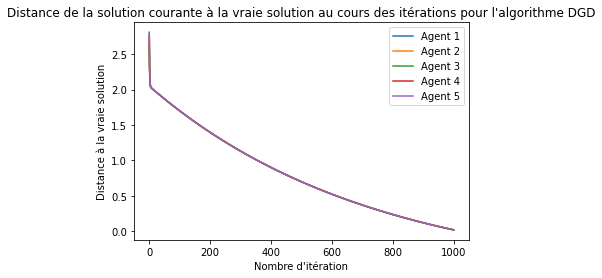

In [55]:
plt.plot(solver_DGD.distance_to_optimum)
plt.xlabel("Nombre d'itération")
plt.ylabel("Distance à la vraie solution")
plt.title("Distance de la solution courante à la vraie solution au cours des itérations pour l'algorithme DGD")
plt.legend(["Agent 1","Agent 2","Agent 3","Agent 4","Agent 5"])
plt.show()

**Gradient tracking**

In [51]:
solver_gradient_tracking = gradient_tracking(instance_pb,0.0001,10000,np.ones(10))
solver_gradient_tracking.solve()
print(solver_gradient_tracking.curent_solution)

Iterration : 0
Agent 0 norme du gradient (gradient like) : 1134.6476041865787
Agent 1 norme du gradient (gradient like) : 1297.1211201895505
Agent 2 norme du gradient (gradient like) : 1364.9542821365694
Agent 3 norme du gradient (gradient like) : 1191.2257421685702
Agent 4 norme du gradient (gradient like) : 1169.2313259885916
Agent 1 objective : 8777.083956817421
Agent 2 objective : 8680.81999731225
Agent 3 objective : 8642.00689769273
Agent 4 objective : 8743.346982453919
Agent 5 objective : 8756.704993381698
Iterration : 1
Agent 0 norme du gradient (gradient like) : 1157.4327209451085
Agent 1 norme du gradient (gradient like) : 1209.9044193874593
Agent 2 norme du gradient (gradient like) : 1223.7350519937693
Agent 3 norme du gradient (gradient like) : 1194.10972346249
Agent 4 norme du gradient (gradient like) : 1119.895909273225
Agent 1 objective : 8067.514403947213
Agent 2 objective : 8001.012904805301
Agent 3 objective : 7982.505319357971
Agent 4 objective : 8023.401863362994
Age

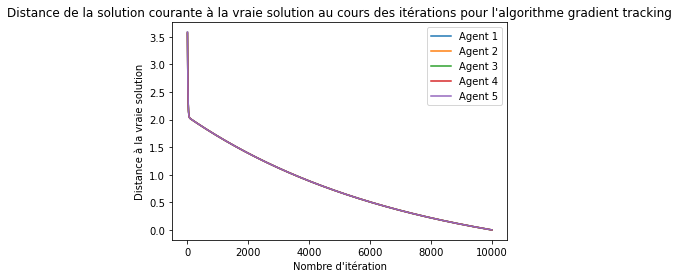

In [54]:
plt.plot(solver_gradient_tracking.distance_to_optimum)
plt.xlabel("Nombre d'itération")
plt.ylabel("Distance à la vraie solution")
plt.legend(["Agent 1","Agent 2","Agent 3","Agent 4","Agent 5"])
plt.title("Distance de la solution courante à la vraie solution au cours des itérations pour l'algorithme gradient tracking")
plt.show()

**Dual decomposition : cloud fashion** Nous avons choisi de tester les deux versions de la dual decompotition : celle ou les multiplicateurs de lagrange sont mis a jour globalment (la version "cloud"), et celle ou ils "vivent" sur les arrêtes du graphe de communication (la version "edge")
Ici, il faut faire attention à un léger détail. L'instance doit être redéfinie et on doit passer en paramètre une matrice d'adjacence (et non plus une matrice stochastique)

In [56]:
instance_pb = instance(x_shuffle,x_selected,y_shuffle,agents_x,agents_y,M4,0.5)
#on doit aussi recalculer la "vraie solution"
solver_non_cooperative = gradient_descent(instance_pb,0.0001,2000,np.ones(10))
instance_pb.true_solution =  solver_non_cooperative.solve()

Objective : 6057.0759307906055
Objective : 3888.003480125268
Objective : 2506.243335172002
Objective : 1626.0172142862207
Objective : 1065.27856367823
Objective : 708.0600398392922
Objective : 480.48809376722767
Objective : 335.50377565636757
Objective : 243.12957823464367
Objective : 184.26921896914516
Objective : 146.7579758366079
Objective : 122.84667126540161
Objective : 107.5989189794808
Objective : 97.87013779516322
Objective : 91.65716274176067
Objective : 87.68393417839
Objective : 85.13757337260651
Objective : 83.50025729909805
Objective : 82.44211948060773
Objective : 81.75302565300188
Objective : 81.29911348022974
Objective : 80.99510747037188
Objective : 80.78668301415908
Objective : 80.63923191798004
Objective : 80.53070581852832
Objective : 80.44705729066902
Objective : 80.37933573854122
Objective : 80.32183741714992
Objective : 80.27092695648848
Objective : 80.22428664643539
Objective : 80.18043821398989
Objective : 80.13843818370994
Objective : 80.09768381422735
Objecti

In [77]:
solver_dual_decomposition = dual_decomposition(instance_pb,0.0001,0.0001,100,300,np.ones(10),np.ones(50))
solver_dual_decomposition.solve()
print(solver_dual_decomposition.curent_primal_solution)

Iteration : 0
Norme du gradient : 0.027116844991915856
Agent 1 objective : 8775.218834889529
Agent 2 objective : 8680.81999731225
Agent 3 objective : 8642.00689769273
Agent 4 objective : 8743.346982453919
Agent 5 objective : 8758.568128107116
Iteration : 1
Norme du gradient : 0.2888330958734875
Agent 1 objective : 89.01945850670748
Agent 2 objective : 81.06707693209131
Agent 3 objective : 82.1127508532702
Agent 4 objective : 87.01651821025843
Agent 5 objective : 87.96885576787716
Iteration : 2
Norme du gradient : 0.3361047572663073
Agent 1 objective : 80.97647977093514
Agent 2 objective : 80.14630658005892
Agent 3 objective : 81.93512491546232
Agent 4 objective : 82.57332690064948
Agent 5 objective : 81.54518493151083
Iteration : 3
Norme du gradient : 0.39679898544919123
Agent 1 objective : 80.16018779155229
Agent 2 objective : 80.11317226467337
Agent 3 objective : 80.66816525721296
Agent 4 objective : 82.90826962486618
Agent 5 objective : 81.14471825188443
Iteration : 4
Norme du gradi

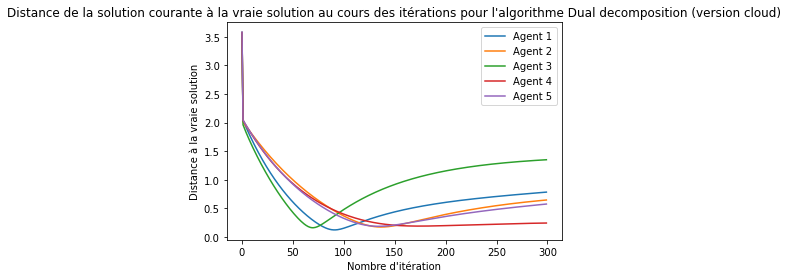

In [79]:
plt.plot(solver_dual_decomposition.distance_to_optimum)
plt.xlabel("Nombre d'itération")
plt.ylabel("Distance à la vraie solution")
plt.legend(["Agent 1","Agent 2","Agent 3","Agent 4","Agent 5"])
plt.title("Distance de la solution courante à la vraie solution au cours des itérations pour l'algorithme Dual decomposition (version cloud)")
plt.show()

**Dual decomposition : edge fashion**

In [81]:
solver_dual_decomposition_edge = dual_decomposition_edge(instance_pb,0.0001,0.0001,100,100,np.ones(10),np.ones(10))
solver_dual_decomposition_edge.solve()
print(solver_dual_decomposition_edge.curent_primal_solution)

Iteration : 0
Agent 1 objective : 8777.083956817421
Agent 2 objective : 8680.81999731225
Agent 3 objective : 8642.00689769273
Agent 4 objective : 8743.346982453919
Agent 5 objective : 8756.704993381698
Iteration : 1
Agent 1 objective : 90.51684998122337
Agent 2 objective : 81.06707768196279
Agent 3 objective : 82.11274956831477
Agent 4 objective : 87.0165172032903
Agent 5 objective : 86.75669236509897
Iteration : 2
Agent 1 objective : 81.42435947491138
Agent 2 objective : 80.14630578021904
Agent 3 objective : 81.93510044930962
Agent 4 objective : 82.57331219437567
Agent 5 objective : 81.27213636490148
Iteration : 3
Agent 1 objective : 80.53821677155017
Agent 2 objective : 80.11316441219898
Agent 3 objective : 80.66812753594598
Agent 4 objective : 82.90821123386827
Agent 5 objective : 80.9312384853376
Iteration : 4
Agent 1 objective : 79.76275271035404
Agent 2 objective : 80.15060270493673
Agent 3 objective : 79.5786117463688
Agent 4 objective : 83.1093067741969
Agent 5 objective : 80.5

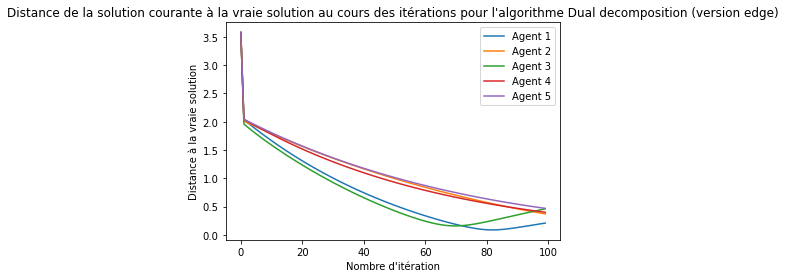

In [83]:
plt.plot(solver_dual_decomposition_edge.distance_to_optimum)
plt.xlabel("Nombre d'itération")
plt.ylabel("Distance à la vraie solution")
plt.legend(["Agent 1","Agent 2","Agent 3","Agent 4","Agent 5"])
plt.title("Distance de la solution courante à la vraie solution au cours des itérations pour l'algorithme Dual decomposition (version edge)")
plt.show()

**ADMM** 

In [87]:
solver_ADMM = ADMM(instance_pb,0.001,1000,np.ones(10),np.ones(10),50)
solver_ADMM.solve()
print(solver_ADMM.curent_solution)

Iteration : 0
Agent 1 objective : 3780.656618862447
Agent 2 objective : 3177.801971095967
Agent 3 objective : 2949.4824206083354
Agent 4 objective : 3563.6924934134936
Agent 5 objective : 3648.854510632835
Iteration : 1
Agent 1 objective : 1522.8899298789804
Agent 2 objective : 1115.6978582894349
Agent 3 objective : 976.2389373035867
Agent 4 objective : 1370.0153133262781
Agent 5 objective : 1425.5898257865108
Iteration : 2
Agent 1 objective : 641.3885846353907
Agent 2 objective : 429.38317469171164
Agent 3 objective : 362.5977865806346
Agent 4 objective : 559.2791419164566
Agent 5 objective : 586.0083233161896
Iteration : 3
Agent 1 objective : 300.3431043870596
Agent 2 objective : 198.4851292323444
Agent 3 objective : 168.68226276217598
Agent 4 objective : 260.1313041527363
Agent 5 objective : 271.1730011830329
Iteration : 4
Agent 1 objective : 168.50763279819927
Agent 2 objective : 120.28065304915458
Agent 3 objective : 107.27862786891006
Agent 4 objective : 149.38458336860378
Agent 

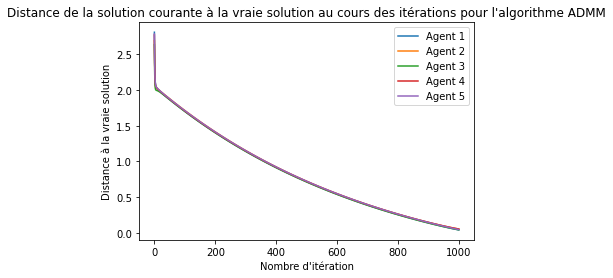

In [88]:
plt.plot(solver_ADMM.distance_to_optimum)
plt.xlabel("Nombre d'itération")
plt.ylabel("Distance à la vraie solution")
plt.legend(["Agent 1","Agent 2","Agent 3","Agent 4","Agent 5"])
plt.title("Distance de la solution courante à la vraie solution au cours des itérations pour l'algorithme ADMM")
plt.show()

### Visualisation de la fonction obtenue

In [102]:
def f(alpha,x_selected,x):
    number_of_kernels = np.shape(x_selected)[0]
    kernels = np.array([kernel(x,x_selected[i]) for i in range(number_of_kernels)])
    return(np.dot(alpha,kernels))

In [108]:
t = np.linspace(-1,1,250)

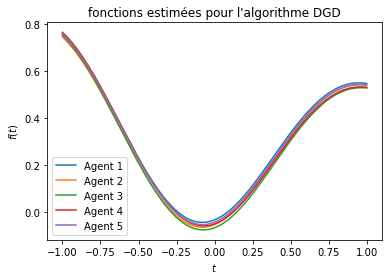

In [109]:
alpha = solver_DGD.curent_solution
f_de_t = np.array([f(alpha,x_selected,t[i])for i in range(250)])
plt.plot(t,f_de_t)
plt.title("fonctions estimées pour l'algorithme DGD")
plt.xlabel("$t$")
plt.ylabel("$f(t)$")
plt.legend(["Agent 1","Agent 2","Agent 3","Agent 4","Agent 5"])
plt.show()

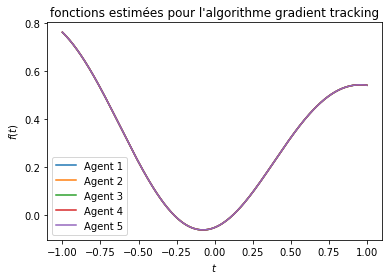

In [110]:
alpha = solver_gradient_tracking.curent_solution
f_de_t = np.array([f(alpha,x_selected,t[i])for i in range(250)])
plt.plot(t,f_de_t)
plt.title("fonctions estimées pour l'algorithme gradient tracking")
plt.xlabel("$t$")
plt.ylabel("$f(t)$")
plt.legend(["Agent 1","Agent 2","Agent 3","Agent 4","Agent 5"])
plt.show()

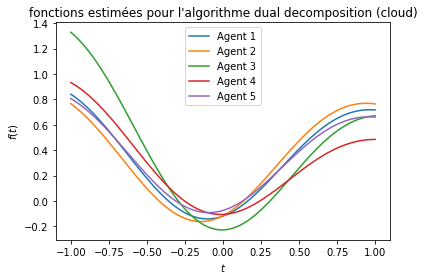

In [113]:
alpha = solver_dual_decomposition.curent_primal_solution
f_de_t = np.array([f(alpha,x_selected,t[i])for i in range(250)])
plt.plot(t,f_de_t)
plt.title("fonctions estimées pour l'algorithme dual decomposition (cloud)")
plt.xlabel("$t$")
plt.ylabel("$f(t)$")
plt.legend(["Agent 1","Agent 2","Agent 3","Agent 4","Agent 5"])
plt.show()

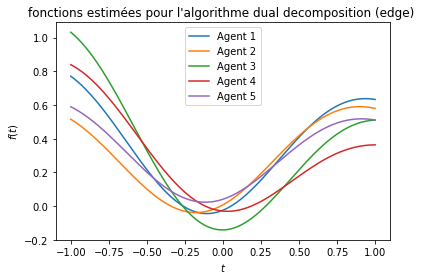

In [114]:
alpha = solver_dual_decomposition_edge.curent_primal_solution
f_de_t = np.array([f(alpha,x_selected,t[i])for i in range(250)])
plt.plot(t,f_de_t)
plt.title("fonctions estimées pour l'algorithme dual decomposition (edge) ")
plt.xlabel("$t$")
plt.ylabel("$f(t)$")
plt.legend(["Agent 1","Agent 2","Agent 3","Agent 4","Agent 5"])
plt.show()

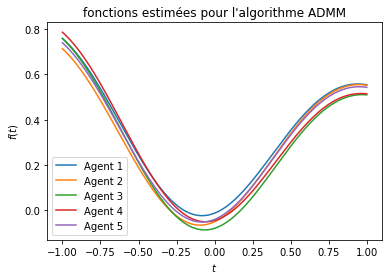

In [115]:
alpha = solver_ADMM.curent_solution
f_de_t = np.array([f(alpha,x_selected,t[i])for i in range(250)])
plt.plot(t,f_de_t)
plt.title("fonctions estimées pour l'algorithme ADMM")
plt.xlabel("$t$")
plt.ylabel("$f(t)$")
plt.legend(["Agent 1","Agent 2","Agent 3","Agent 4","Agent 5"])
plt.show()